In [1]:


import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Carrega o dataset como dataframe
df = pd.read_csv('dataset/video_games_2016.csv')

In [3]:
# Remove outliers
Q1 = df['Global_Sales'].quantile(0.00)
Q3 = df['Global_Sales'].quantile(0.98)

df = df[(df['Global_Sales'] >= Q1 ) & (df['Global_Sales'] <= Q3 )]

In [4]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

df['Greatest'] = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)

In [5]:

print ( df["Critic_Score"].isna().sum() )
print ( df["Critic_Count"].isna().sum() )
print ( df["Global_Sales"].isna().sum() )
print ( df["NA_Sales"].isna().sum() )
print ( df["EU_Sales"].isna().sum() )
print ( df["JP_Sales"].isna().sum() )
print ( df["Other_Sales"].isna().sum() )

8478
8478
0
0
0
0
0


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Split data into training and prediction subsets
train_data = df[df['Critic_Score'].notna()]
predict_data = df[df['Critic_Score'].isna()]


train_data_count   = df[df['Critic_Count'].notna()]
predict_data_count = df[df['Critic_Count'].isna()]

# Step 2: Define the feature columns
categorical_features = ['Genre', 'Platform', "Publisher", "Developer"]
numeric_features = [
    'Global_Sales',
    'NA_Sales',
    'EU_Sales',
    'JP_Sales',
    'Other_Sales'
]

# Step 3: Create a pipeline for preprocessing and model training
# OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

# RandomForestRegressor as the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Step 4: Train the model on rows with known 'Critic_Score'
X_train = train_data[categorical_features + numeric_features]
y_train = train_data['Critic_Score']

model.fit(X_train, y_train)

# Step 5: Predict missing values
X_predict = predict_data[categorical_features + numeric_features]
predicted_scores = model.predict(X_predict)


X_train = train_data_count[categorical_features + numeric_features]
y_train = train_data_count['Critic_Count']

model.fit(X_train, y_train)

X_predict = predict_data[categorical_features + numeric_features]
predicted_count = model.predict(X_predict)

# Step 6: Fill the missing values in the original DataFrame
df.loc[df['Critic_Score'].isna(), 'Critic_Score'] = predicted_scores
df.loc[df['Critic_Count'].isna(), 'Critic_Count'] = predicted_count



print(df)


In [ ]:
fill_0 = [
    "Critic_Score",
    "Critic_Count",
    "User_Score",
    "User_Count",
]

fill_mean = [
    'Year_of_Release',
    'Global_Sales'
]

for c in fill_0 :
    df[c] = df[c].fillna(0)

for c in fill_mean :
    df[c] = df[c].fillna(df[c].mean())


In [ ]:
df["Platform_Code"] = df[ "Platform" ].astype("category").cat.codes

In [ ]:
fdf = df.copy()

def reduce_platforms( l ):
    s = 0;
    for i in l:
        s |= 1 << i+1
    return s

grouped = fdf.groupby( "Name" )

a = grouped.agg(
    Genre=("Genre", "first"),
    Developer=("Developer", "first"),
    # Greatest=("Gret", "first"),
    Publisher=("Publisher", "first"),
    Year_of_Release=("Year_of_Release", "first"),
    Rating=("Rating", "first"),

    Count_Platforms=("Name", "count"),

    Platform_Codes=("Platform_Code", reduce_platforms),

    Global_Sales=("Global_Sales", "sum"),
    NA_Sales=("NA_Sales", "sum"),
    EU_Sales=("EU_Sales", "sum"),
    JP_Sales=("JP_Sales", "sum"),
    Other_Sales=("Other_Sales", "sum"),

    True_Score=("Critic_Score", "max"), 
    User_Score=("User_Score", "max"), 

    User_Count=("User_Count", "sum"), 
    Critic_Count=("Critic_Count", "sum"), 
    # True_Score=("Critic_Score", lambda x: (x * grouped["Critic_Count"].get_group(x.name)).sum() / grouped["Critic_Count"].get_group(x.name).sum()), 
    # Critic_Score=("Critic_Score", lambda x: x)
).reset_index()

a.sort_values("Count_Platforms", ascending=False).head(4)

,Name,Genre,Developer,Publisher,Year_of_Release,Rating,Count_Platforms,Platform_Codes,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales,True_Score,User_Score,User_Count,Critic_Count
6637,Need for Speed: Most Wanted,Racing,EA Canada,Electronic Arts,2012.0,T,11,1881424288,9.40,4.20,3.88,0.10,1.22,84.14,9.1,1405.0,307.67
5088,LEGO Marvel Super Heroes,Action,TT Games,Warner Bros. Interactive Entertainment,2013.0,E10+,9,2955690024,9.44,4.31,3.91,0.08,1.11,83.00,8.1,749.0,169.51
7680,Ratatouille,Action,Asobo Studio,THQ,2007.0,E,9,672547232,4.41,2.03,1.35,0.00,0.99,70.10,8.0,50.0,87.82
5085,LEGO Jurassic World,Action,TT Games,Warner Bros. Interactive Entertainment,2015.0,E10+,8,2955689992,4.67,2.15,1.91,0.07,0.56,75.02,8.1,219.0,181.26


In [ ]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

a['Greatest'] = a[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)

/tmp/ipykernel_1715796/2260312164.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


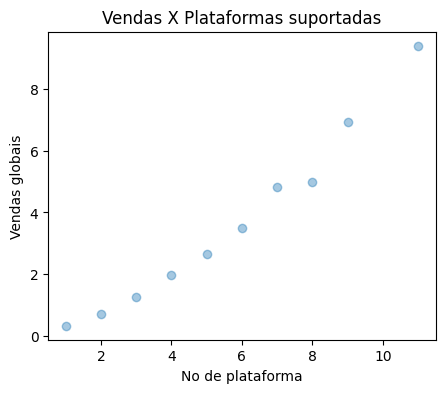

In [ ]:
fdf = a
fdf = fdf.groupby("Count_Platforms")["Global_Sales"].mean().reset_index()


plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['Count_Platforms'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('No de plataforma')

plt.title('Vendas X Plataformas suportadas')

plt.show()

/tmp/ipykernel_1715796/1975271398.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


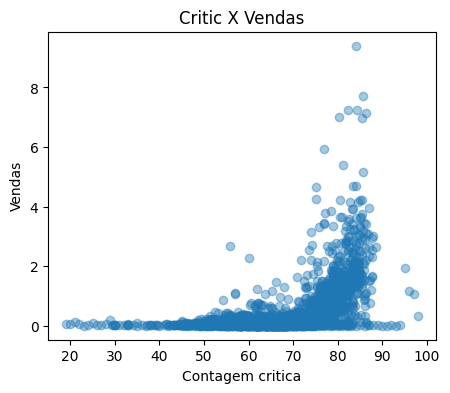

In [ ]:

fdf = a

min_sales = fdf.groupby('True_Score')['Global_Sales'].min().reset_index()

plt.figure(figsize=(5, 4))
plt.scatter( 
  min_sales['True_Score'],
  min_sales['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas')
plt.xlabel('Contagem critica')

plt.title('Critic X Vendas')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
target = 'Global_Sales'

numeric_features = [ 
    "Count_Platforms",
    'True_Score',
    # 'Critic_Count',
    # 'Platform_Codes'
]  

categorical_features = [
    # 'Genre',
    # 'Year_of_Release',
    # 'Publisher',
    # 'Developer',
    # 'Rating'
]  


norm = lambda col: (col - col.min()) / ( col.max() - col.min() ) 

to_norm = [
    "Platform_Codes",
    "Critic_Count",
    "True_Score",
]

for col in to_norm:
    fdf[col] = norm(fdf[col])

fdf = a.copy()

fdf[categorical_features] = fdf[categorical_features].fillna('NA')  

X = fdf[numeric_features + categorical_features]
y = fdf[ target ]  
y = np.log1p(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True) , numeric_features),
        # ('num', "passthrough" , numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

gdboost = GradientBoostingRegressor(
    random_state=0,
    learning_rate=0.05,
    max_depth=10,
    n_estimators=800,
    min_samples_split=20,
    min_samples_leaf=10 
)

rforest = RandomForestRegressor( 
    random_state=42,
    max_depth=9,
    n_estimators=800
)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', gdboost )
                                #  ('regressor', rforest)
                                #  ('regressor', LinearRegression())
                                #  ('regressor', Ridge())
                                 ])


In [ ]:
model_pipeline.fit(X_train, y_train)
y_pred= model_pipeline.predict(X_test)

In [ ]:
from sklearn.inspection import permutation_importance

# Transform the training data using the preprocessor and convert to dense
X_train_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train).toarray()

# Compute permutation importance
feature_importance = permutation_importance(
    model_pipeline.named_steps['regressor'], 
    X_train_transformed,  # Dense array
    y_train, 
    n_repeats=10, 
    random_state=0
)

# Display feature importance
print(feature_importance.importances_mean)

[ 4.06380716e-04  1.35417241e-01  3.02443643e-02  8.31024623e-03
  1.55756330e-01  2.66696704e-02  8.17154378e-03  4.64155197e-01
  7.03938480e-02  5.63456112e-02  8.18589375e-03  4.69311650e-04
  5.92437280e-03  3.87858070e-03  2.93284701e-03  5.85968311e-04
  1.73188547e-03  3.82845266e-03  2.85849064e-03  1.30756834e-03
  6.84941870e-03  8.52985569e-05  0.00000000e+00 -1.38277108e-06
  0.00000000e+00  2.66503976e-06  6.93938112e-04  9.49038368e-04
  1.14217894e-04  1.79738591e-05  4.13216145e-04  0.00000000e+00
  1.01778737e-03  0.00000000e+00  1.82271264e-04  6.46347593e-04
  8.26774630e-04  7.53280500e-04  5.50041092e-03  1.28500101e-03
  3.61399333e-03  4.81508907e-03  2.44280117e-03  2.11205980e-04
  9.32480102e-04  3.36633298e-03  6.30781038e-03  4.09135392e-04
  2.41842818e-03  1.17655689e-03  7.09725622e-04  2.57307964e-04
  1.09442974e-03  5.33556031e-04  3.70584450e-04  6.63353269e-04
  4.99816321e-03  8.80929627e-03  0.00000000e+00  0.00000000e+00]


In [ ]:
# Get feature names for numeric features (PolynomialFeatures)
poly_feature_names = model_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(numeric_features)

# Get feature names for categorical features (OneHotEncoder)
cat_feature_names = model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = list(poly_feature_names) + list(cat_feature_names)

# Map importance values to feature names
feature_importance_dict = dict(zip(all_feature_names, feature_importance.importances_mean))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display top features
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.6f}")

True_Score Critic_Count: 0.464155
Count_Platforms True_Score: 0.155756
True_Score: 0.135417
True_Score Platform_Codes: 0.070394
Critic_Count Platform_Codes: 0.056346
Critic_Count: 0.030244
Count_Platforms Critic_Count: 0.026670
Year_of_Release_2016.0: 0.008809
Platform_Codes: 0.008310
Genre_Adventure: 0.008186
Count_Platforms Platform_Codes: 0.008172
Genre_Strategy: 0.006849
Year_of_Release_2006.0: 0.006308
Genre_Misc: 0.005924
Year_of_Release_1998.0: 0.005500
Year_of_Release_2015.0: 0.004998
Year_of_Release_2001.0: 0.004815
Genre_Platform: 0.003879
Genre_Shooter: 0.003828
Year_of_Release_2000.0: 0.003614
Year_of_Release_2005.0: 0.003366
Genre_Puzzle: 0.002933
Genre_Simulation: 0.002858
Year_of_Release_2002.0: 0.002443
Year_of_Release_2007.0: 0.002418
Genre_Role-Playing: 0.001732
Genre_Sports: 0.001308
Year_of_Release_1999.0: 0.001285
Year_of_Release_2008.0: 0.001177
Year_of_Release_2011.0: 0.001094
Year_of_Release_1992.0: 0.001018
Year_of_Release_1987.0: 0.000949
Year_of_Release_2004.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.07947571268471382
R-squared: 0.5154577626316028


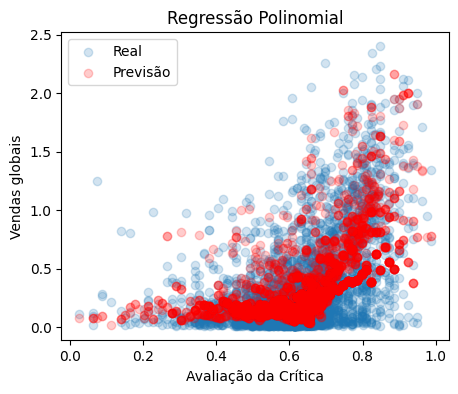

In [ ]:
plt.figure(figsize=(5, 4))
plt.scatter(X_test['True_Score'], y_test, alpha=0.2, label='Real')

plt.scatter(X_test["True_Score"], y_pred, color='red', alpha=0.2, label='Previsão')

plt.xlabel('Avaliação da Crítica')
plt.ylabel('Vendas globais')
plt.title('Regressão Polinomial')
plt.legend()
plt.show()

/home/wolke/Documents/datascience/topicos-4/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


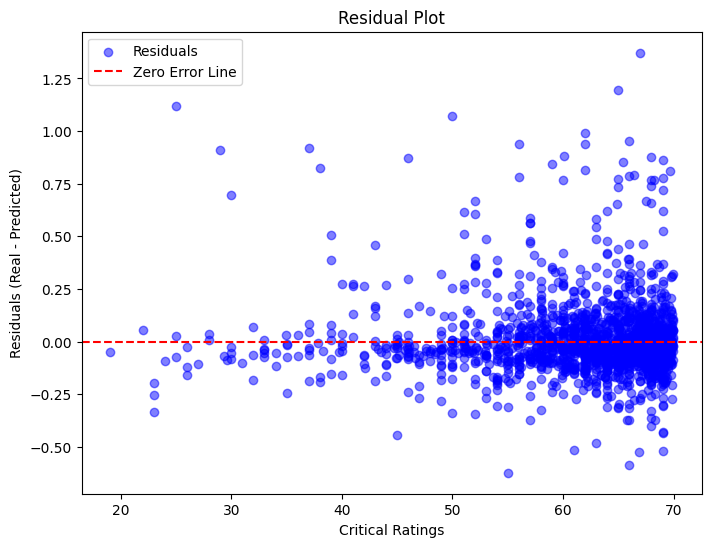

In [ ]:
y_pred = model_pipeline.predict(X_test)

residuals = y_test - y_pred

x_axis_values = X_test['True_Score'] 

plt.figure(figsize=(8, 6))
plt.scatter(x_axis_values, residuals, alpha=0.5, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

plt.title('Residual Plot')
plt.xlabel('Critical Ratings')
plt.ylabel('Residuals (Real - Predicted)')
plt.legend()
plt.show()
